# Building General Dynamical Systems

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](mailto:adaduo@outlook.com)

The previous sections have shown how to build neuron models, synapse models, and network models. In fact, these brain objects all inherit the base class [brainpy.dyn.DynamicalSystem](../apis/auto/dyn/generated/brainpy.dyn.base.DynamicalSystem.rst), ``brainpy.dyn.DynamicalSystem`` is the universal language to define dynamical models in BrainPy.

To begin with, let's make a rief summary of previous dynamic models and give the definition of a dynamical system.

In [6]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

## What is a dynamical system?

Looking back to the neuron and synapse models defined in the previous sections, they share a common feature that **they all contain some variables that change over time**. Because of these variables, the models become 'dynamic' and behave differently at different times.

Actually, a *dynamical system* is defined as a system with time-dependent states. These time-dependent states are displayed as variables in the previous models.

Mathematically, the change of a state $X$ can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describing the time dependence of the state. 

Alternatively, the evolution of the system over time can be given by

$$
X(t+dt) = F\left(X(t), t, dt\right)
$$

where $dt$ is the time step and $F$ is the evolution rule to update the system's state.

## Customizing your dynamical systems

According to the mathematical expression of a dynamical system, any subclass of ``brainpy.dyn.DynamicalSystem`` must implement an updating rule in the ``update(self, t, dt)`` function.

To define a dynamical system, the following requirements should be satisfied:
- Inherit from `brainpy.dyn.DynamicalSystem`.
- Implement the `update(self, t, dt)` function.
- When defining variables, they should be declared as `brainpy.math.Variable`.
- When updating the variables, it should be realized by [in-place operations](./tutorial_basics/tensors_and_variables.ipynb).

Below is a simple example of a dynamical system.

In [7]:
class FitzHughNagumoModel(bp.dyn.DynamicalSystem):
    def __init__(self, a=0.8, b=0.7, tau=12.5, **kwargs):
        super(FitzHughNagumoModel, self).__init__(**kwargs)
        
        # parameters
        self.a = a
        self.b = b
        self.tau = tau
        
        # variables should be packed by brainpy.math.Variable
        self.v = bm.Variable([0.])
        self.w = bm.Variable([0.])
        self.I = bm.Variable([0.])
        
    def update(self, _t, _dt):
        # _t : the current time, the system keyword 
        # _dt : the time step, the system keyword 
        
        # in-place update
        self.w += (self.v + self.a - self.b * self.w) / self.tau * _dt
        self.v += (self.v - self.v ** 3 / 3 - self.w + self.I) * _dt
        self.I[:] = 0.

Here, we have defined a dynamical system called [FitzHugh–Nagumo neuron model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

By using the [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst), this system can be updated by the following rule:

$$
\begin{aligned}
v(t+dt) &= v(t) + [v(t)-{v(t)^{3}/3}-w(t)+RI] * dt, \\
w(t + dt) &= w(t) + [v(t) + a - b w(t)] * dt.
\end{aligned}
$$

## Advantages of using `brainpy.dyn.DynamicalSystem`

There are several advantages of defining a dynamical system as `brainpy.dyn.DynamicalSystem`. 

### 1. A systematic naming system. 

First, every instance of ``DynamicalSystem`` has its unique name.

In [8]:
fhn = FitzHughNagumoModel()

In [9]:
fhn.name  # name for "fhn" instance

'FitzHughNagumoModel1'

Every instance has its unique name:

In [10]:
for _ in range(3):
    print(FitzHughNagumoModel().name)

FitzHughNagumoModel2
FitzHughNagumoModel3
FitzHughNagumoModel4


Users can also specify the name of a dynamic system:

In [11]:
fhn2 = FitzHughNagumoModel(name='X')

fhn2.name

'X'

In [12]:
# same name will cause error

try:
    FitzHughNagumoModel(name='X')
except bp.errors.UniqueNameError as e:
    print(e)

In BrainPy, each object should have a unique name. However, we detect that <__main__.FitzHughNagumoModel object at 0x000001F75163C250> has a used name "X". 
If you try to run multiple trials, you may need 

>>> brainpy.base.clear_name_cache() 

to clear all cached names. 


Second, variables, children nodes, etc. inside an instance can be easily accessed by their *absolute* or *relative* path. 

In [13]:
# All variables can be acessed by 
# 1). the absolute path

fhn2.vars()

{'X.I': Variable([0.], dtype=float32),
 'X.v': Variable([0.], dtype=float32),
 'X.w': Variable([0.], dtype=float32)}

In [14]:
# 2). or, the relative path

fhn2.vars(method='relative')

{'I': Variable([0.], dtype=float32),
 'v': Variable([0.], dtype=float32),
 'w': Variable([0.], dtype=float32)}

### 2. Convenient operations for simulation and analysis.
Brainpy provides different runners for dynamics simulation and analyzers for dynamics analysis, both of which require the dynamic model to be `Brainpy.dyn.DynamicalSystem`. For example, dynamic models can be packed by a runner for simulation:

  0%|          | 0/1000 [00:00<?, ?it/s]

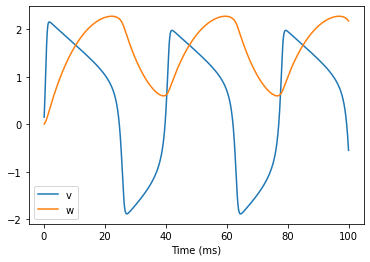

In [15]:
runner = bp.dyn.DSRunner(fhn2, monitors=['v', 'w'], inputs=('I', 1.5))
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon.v, legend='v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

Please see [Runners](../tutorial_toolbox/runners.ipynb) to know more about the operations in runners.

### 3. Efficient computation.

``brainpy.dyn.DynamicalSystem`` is a subclass of [brainpy.Base](../apis/generated/brainpy.base.Base.rst), and therefore, any instance of ``brainpy.dyn.DynamicalSystem`` can be complied [just-in-time](../tutorial_basics/jit_compilation.ipynb) into efficient machine codes targeting on CPUs, GPUs, and TPUs. 

  0%|          | 0/1000 [00:00<?, ?it/s]

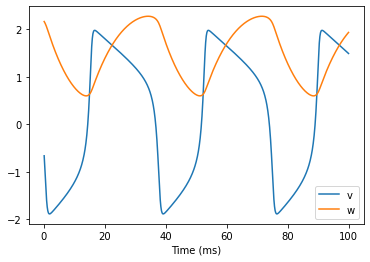

In [16]:
runner = bp.dyn.DSRunner(fhn2, monitors=['v', 'w'], inputs=('I', 1.5), jit=True)
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon.v, legend='v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

### 4. Support composable programming.
Instances of ``brainpy.dyn.DynamicalSystem`` can be combined at will. The combined system is also a `brainpy.dyn.DynamicalSystem` and enjoys all the properties, methods, and interfaces provided by `brainpy.dyn.DynamicalSystem`.

For example, if the instances are wrapped into a container, i.e. `brainpy.dyn.Network`, variables and nodes can also be accessed by their absolute or relative path.

In [17]:
fhn_net = bp.dyn.Network(f1=fhn, f2=fhn2)

In [18]:
# absolute access of variables

fhn_net.vars()

{'FitzHughNagumoModel1.I': Variable([0.], dtype=float32),
 'FitzHughNagumoModel1.v': Variable([0.], dtype=float32),
 'FitzHughNagumoModel1.w': Variable([0.], dtype=float32),
 'X.I': Variable([0.], dtype=float32),
 'X.v': Variable([1.492591], dtype=float32),
 'X.w': Variable([1.9365357], dtype=float32)}

In [19]:
# relative access of variables

fhn_net.vars(method='relative')

{'f1.I': Variable([0.], dtype=float32),
 'f1.v': Variable([0.], dtype=float32),
 'f1.w': Variable([0.], dtype=float32),
 'f2.I': Variable([0.], dtype=float32),
 'f2.v': Variable([1.492591], dtype=float32),
 'f2.w': Variable([1.9365357], dtype=float32)}

In [20]:
# absolute access of nodes

fhn_net.nodes()

{'FitzHughNagumoModel1': <__main__.FitzHughNagumoModel at 0x1f7515a74c0>,
 'X': <__main__.FitzHughNagumoModel at 0x1f75164bd90>,
 'Network0': <brainpy.dyn.base.Network at 0x1f7529e70d0>}

In [21]:
# relative access of nodes

fhn_net.nodes(method='relative')

{'': <brainpy.dyn.base.Network at 0x1f7529e70d0>,
 'f1': <__main__.FitzHughNagumoModel at 0x1f7515a74c0>,
 'f2': <__main__.FitzHughNagumoModel at 0x1f75164bd90>}

  0%|          | 0/1000 [00:00<?, ?it/s]

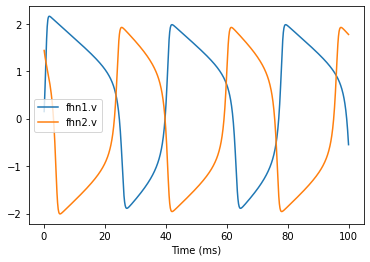

In [22]:
runner = bp.dyn.DSRunner(fhn_net,
                         monitors=['f1.v', 'X.v'], 
                         inputs=[('f1.I', 1.5),   # relative access to variable "I" in 'fhn1'
                                 ('X.I', 1.0),])  # absolute access to variable "I" in 'fhn2'
runner(duration=100)

bp.visualize.line_plot(runner.mon.ts, runner.mon['f1.v'], legend='fhn1.v', show=False)
bp.visualize.line_plot(runner.mon.ts, runner.mon['X.v'], legend='fhn2.v', show=True)